# **Import Packages**

In [9]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import shutil
import random

import warnings
warnings.filterwarnings('ignore')

# **Unzipping Data**

In [10]:
_ = !unzip /kaggle/input/dogs-vs-cats/train.zip
print("Done!")

Done!


In [11]:
_ = !unzip /kaggle/input/dogs-vs-cats/test1.zip
print("Done!")

Done!


# **Data Visualization**

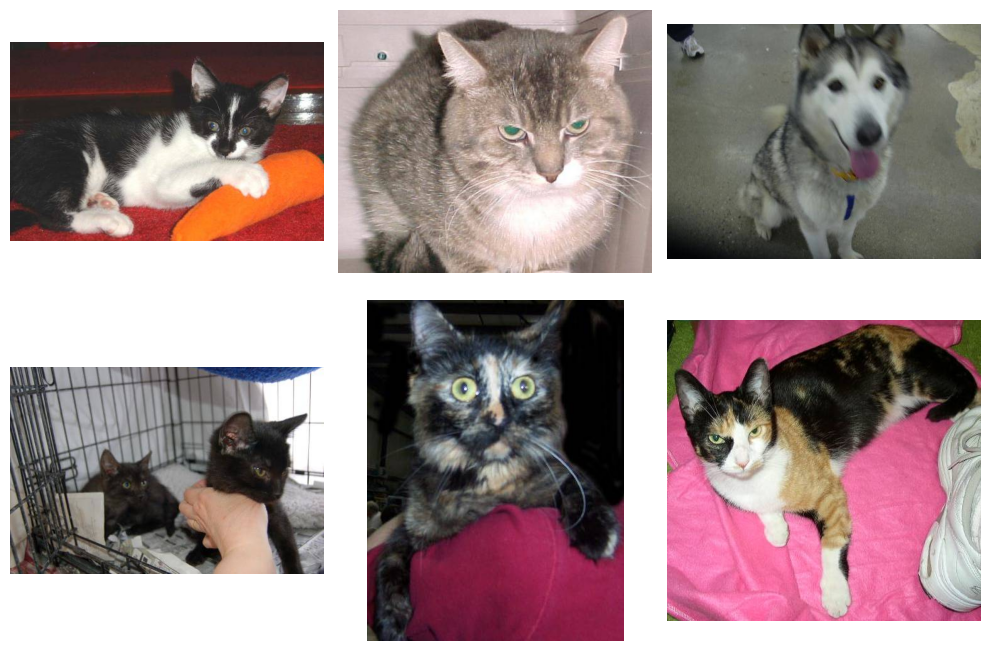

In [12]:
train_dir = '/kaggle/working/train'

all_images = os.listdir(train_dir)

random_images = random.sample(all_images, 6)

plt.figure(figsize=(10, 7))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(train_dir, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


# **Data Organization**

In [9]:
## File Naming
parent_dir = '/kaggle/working/dogs-vs-cats'
os.makedirs(parent_dir)

In [10]:
for dir in ['train', 'validation']:
  os.makedirs(os.path.join(parent_dir, dir))
  for category in ['dog', 'cat']:
    os.makedirs(os.path.join(parent_dir, dir, category))

In [17]:
## Each Class Images
cat_images = list(filter(lambda x: x.startswith('cat'), os.listdir('train')))
dog_images = list(filter(lambda x: x.startswith('dog'), os.listdir('train')))

In [18]:
## Validation Data
cat_val = random.sample(cat_images, int(len(cat_images)*0.1))
dog_val = random.sample(dog_images, int(len(dog_images)*0.1))

In [19]:
## Copying Data
for image in os.listdir('train'):
  if image.startswith('cat'):
    if image in cat_val:
      shutil.copy(os.path.join('train', image), os.path.join(parent_dir, 'validation', 'cat', image))
    else:
      shutil.copy(os.path.join('train', image), os.path.join(parent_dir, 'train', 'cat', image))
  else:
    if image in dog_val:
      shutil.copy(os.path.join('train', image), os.path.join(parent_dir, 'validation', 'dog', image))
    else:
      shutil.copy(os.path.join('train', image), os.path.join(parent_dir, 'train', 'dog', image))

In [21]:
print('Total Training Cat Images:', len(os.listdir('dogs-vs-cats/train/cat')))
print('Total Training Dog Images:', len(os.listdir('dogs-vs-cats/train/dog')))
print('Total Validation Cat Images:', len(os.listdir('dogs-vs-cats/validation/cat')))
print('Total Validation Dog Images:', len(os.listdir('dogs-vs-cats/validation/dog')))

Total Training Cat Images: 11250
Total Training Dog Images: 11250
Total Validation Cat Images: 1250
Total Validation Dog Images: 1250


# **ImageDataGenerator**

In [22]:
image_datagen = ImageDataGenerator(rescale=1/255)

train_dategen = image_datagen.flow_from_directory(
    'dogs-vs-cats/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_dategen = image_datagen.flow_from_directory(
    'dogs-vs-cats/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# **Base Model**

## Model Building & Training

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dategen, epochs=5, validation_data=validation_dategen)

## Base Model Visualization

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

In [ ]:
### Accuracy Visualization
sns.lineplot(history_df[['accuracy', 'val_accuracy']])

In [ ]:
### Loss Visualization
sns.lineplot(history_df[['loss', 'val_loss']])

## Train & Validation Evaluation

In [ ]:
print(model.evaluate(train_dategen)[1])
print(model.evaluate(validation_dategen)[1])

# **Data Augmentation**

In [ ]:
train_image_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.02,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dategen = train_image_datagen.flow_from_directory(
    'dogs-vs-cats/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_dategen = image_datagen.flow_from_directory(
    'dogs-vs-cats/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# **More Complex Model**

## Model Building & Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.best.h5', monitor='val_loss', save_best_only=True)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    BatchNormalization(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dategen, epochs=30, validation_data=validation_dategen, callbacks=[early_stopping, model_checkpoint])

## Model Visualization

In [ ]:
history_df = pd.DataFrame(history.history)

In [ ]:
### Accuracy Visualization
sns.lineplot(history_df[['accuracy', 'val_accuracy']])

In [ ]:
### Loss Visualization
sns.lineplot(history_df[['loss', 'val_loss']])

## Train & Validation Evaluation

In [ ]:
print(model.evaluate(train_dategen)[1])
print(model.evaluate(validation_dategen)[1])

# **Transfer Learning `(VGG16)`**

## ImageDataGenerator

In [ ]:
image_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1/255,
)

train_dategen = image_datagen.flow_from_directory(
    'dogs-vs-cats/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


validation_dategen = image_datagen.flow_from_directory(
    'dogs-vs-cats/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


## Feature Exctraction

In [ ]:
transfer_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

for layer in transfer_model.layers:
  layer.trainable = False

## Model Building & Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_transfer_model.best.h5', monitor='val_loss', save_best_only=True)

model_transfer = Sequential([
    transfer_model,
    Flatten(),
    BatchNormalization(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_transfer.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_transfer.fit(train_dategen, epochs=30, validation_data=validation_dategen, callbacks=[early_stopping, model_checkpoint])

## Model Visualization

In [ ]:
history_df = pd.DataFrame(history.history)

In [ ]:
### Accuracy Visualization
sns.lineplot(history_df[['accuracy', 'val_accuracy']])

In [ ]:
### Loss Visualization
sns.lineplot(history_df[['loss', 'val_loss']])

## Train & Validation Evaluation

In [ ]:
print(model_transfer.evaluate(train_dategen)[1])
print(model_transfer.evaluate(validation_dategen)[1])

# **Test Prediction**

In [ ]:
# Get sorted image filenames
image_files = sorted([f for f in os.listdir('test1')])

# Prepare list for predictions
predictions = []

# Loop through images
for idx, img_name in enumerate(image_files, start=1):
    img_path = os.path.join('test1', img_name)

    # Load and preprocess image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    pred = model_transfer.predict(img_array, verbose=0)
    label = int(pred[0][0] > 0.5)

    # Store (id, label)
    predictions.append({'id': idx, 'label': label})


# Save as submission file
df = pd.DataFrame(predictions)
df.to_csv('submission.csv', index=False)

print("✅ submission.csv created successfully!")
print(df.head())

# **Thanks**